# 02. Preprocesado de Datos Raster

Este notebook se dedica al preprocesamiento de imágenes ráster PNOA IRG para su posterior análisis en el proyecto de detección de balsas. El flujo de trabajo comienza con la optimización de las imágenes GeoTIFF COG originales, extrayendo niveles de menor resolución para reducir la carga computacional. Se genera una versión reducida de todas las imágenes, guardándolas en formato TIFF comprimido y se crea un Virtual Raster (VRT) que combina todas estas imágenes reducidas en un único archivo virtual, facilitando el acceso y el procesamiento unificado de la cobertura ráster completa del área de estudio.


**Objetivo**: Preparar y transformar imágenes raster en crudo (raw) para facilitar su procesamiento posterior en el análisis del proyecto.

**Contenido**:

* Extracción de niveles de menor resolución de las imágenes GeoTIFF COG para optimizar el procesamiento.
* Generación de versiones reducidas de las imágenes GeoTIFF COG originales.
* Creación de un Virtual Raster (VRT) para combinar todas las imágenes reducidas en un solo archivo virtual.
* Comprobación del número de bandas del VRT resultante.

## Importamos librerias necesarias

In [1]:
# Instalar las librerias necesarias
# !pip install xxxxxxx

In [2]:
# Importar librerias necesarias
import os
import glob
from osgeo import gdal
import rasterio
from pathlib import Path
from rasterio.windows import Window
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Extraer niveles de menor resolución de las imágenes GeoTIFF COG 

Para optimizar el procesamiento y análisis en el proyecto de detección de balsas, utilizaremos niveles de resolución más bajos de la imagen TIFF COG. Esto nos permitirá reducir el consumo de recursos computacionales, acelerar los tiempos de procesamiento y mantener una perspectiva adecuada para identificar patrones relevantes sin comprometer la calidad del análisis.

Verificamos los niveles y las resoluciones e una de las imágenes GeoTIFF COG

In [3]:
# Ruta a una de las imagenes GeoTIFF COG
ruta_cog = '../data/raw/raster/PNOA_IRG/PNOA_MA_IRG_OF_ETRS89_HU30_h25_0963_1.tif'

In [4]:
# Función para verificar niveles de piramides y resolucion
def niveles_piramide_y_resoluciones(ruta_cog):
    """
    Verifica los niveles de pirámide disponibles en un GeoTIFF COG y muestra sus resoluciones en píxeles.

    Args:
        ruta_cog: Ruta al archivo GeoTIFF COG.
    """
    try:
        with rasterio.open(ruta_cog) as src:
            # Dimensiones originales de la imagen
            width, height = src.width, src.height
            print(f"Resolución original: {width} x {height} píxeles")

            # Obtener los niveles de pirámide (overviews) para la primera banda
            overviews = src.overviews(1)
            if overviews:
                print(f"\nNiveles de pirámide disponibles: {len(overviews)}")
                print(f"Factores de reducción: {overviews}\n")
                print("Resoluciones aproximadas por nivel:")
                print("-" * 50)
                print(f"{'Nivel':<10}{'Reducción':<15}{'Resolución (ancho x alto)'}")
                print("-" * 50)
                for nivel, reduccion in enumerate(overviews, start=1):
                    redu_width = width // reduccion
                    redu_height = height // reduccion
                    print(f"{nivel:<10}{reduccion:<15}{redu_width} x {redu_height}")
                print("-" * 50)
            else:
                print("No hay niveles de pirámide disponibles en este archivo.")
    except rasterio.errors.RasterioIOError as e:
        print(f"Error al abrir el archivo {ruta_cog}: {e}")

In [5]:
# Llamamos a la función niveles_piramide_y_resoluciones
niveles_piramide_y_resoluciones(ruta_cog)

Resolución original: 60416 x 39168 píxeles

Niveles de pirámide disponibles: 8
Factores de reducción: [2, 4, 8, 16, 32, 64, 128, 256]

Resoluciones aproximadas por nivel:
--------------------------------------------------
Nivel     Reducción      Resolución (ancho x alto)
--------------------------------------------------
1         2              30208 x 19584
2         4              15104 x 9792
3         8              7552 x 4896
4         16             3776 x 2448
5         32             1888 x 1224
6         64             944 x 612
7         128            472 x 306
8         256            236 x 153
--------------------------------------------------


**FACTOR 4**
La resolución original de 60416 x 39168 píxeles (0.25 metros por píxel) genera un volumen de datos excesivamente grande para ser manejado eficientemente en nuestro proyecto de detección de balsas. Este nivel de detalle es innecesario para identificar balsas. Trabajar con la resolución original puede resultar en tiempos de procesamiento más prolongados y un uso elevado de recursos computacionales sin un beneficio significativo en la precisión de la detección.

Por esta razón, utilizaremos el nivel 2 de la pirámide, con un factor de reducción de 4, lo que produce una resolución de 15104 x 9792 píxeles. En este nivel, cada píxel representará 1 metro, lo que consideramos suficiente para identificar las balsas y reducimos la carga computacional.

La reducción al nivel 2 logra un balance óptimo entre la cantidad de datos a procesar y la resolución necesaria para detectar balsas. Al reducir el volumen de píxeles en un 93.75%, optimizamos el rendimiento sin comprometer la calidad del análisis visual ni la detección de elementos clave.

### Visualización de una porción de una imágen GeoTIFF COG

Mostramos la visualizaión de una porción de una imágen GeoTIFF COG en su resolución orginal (0,25 m. píxel) y en su versión reducida (1 m. píxel)

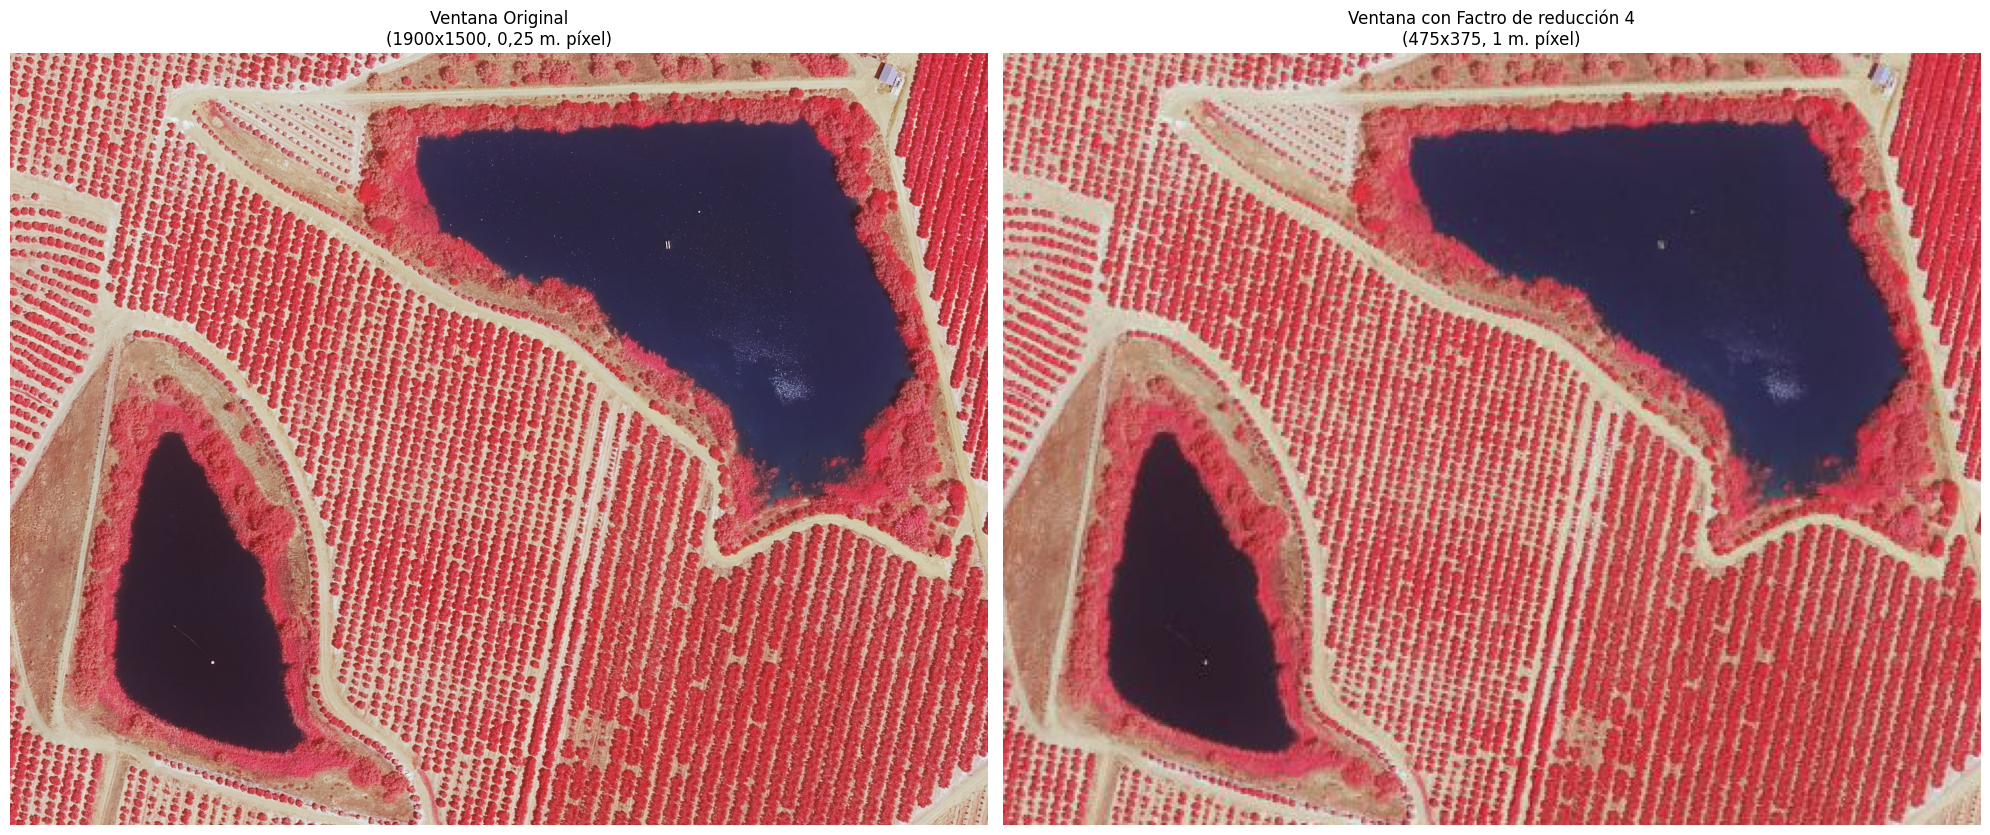

In [6]:
# Ruta al archivo TIFF COG
cog_path = '../data/raw/raster/PNOA_IRG/PNOA_MA_IRG_OF_ETRS89_HU30_h25_0963_4.tif'

# Factor de reducción 
selected_factor = 4  

# Definir la ventana para l avisualización
window_col_off = 29000
window_row_off = 320
window_width = 1900
window_height = 1500

# Leer las tres bandas (I, R, G) dentro de la ventana definida y aplicar el factor de reducción
with rasterio.open(cog_path) as dataset:
    # Verificar si el factor de reducción está disponible en los overviews
    overviews = dataset.overviews(1)
    if selected_factor in overviews:
        # Crear un objeto Window con las dimensiones especificadas
        window = Window(window_col_off, window_row_off, window_width, window_height)
        
        # Leer la ventana en resolución original
        data_original = dataset.read(
            [1, 2, 3],  # Bandas I, R, G
            window=window
        )
        
        # Leer la ventana con el factor de reducción aplicado
        data_reduced = dataset.read(
            [1, 2, 3],  # Bandas I, R, G
            window=window,
            out_shape=(
                3,  # Número de bandas
                int(window_height // selected_factor),  # Altura reducida
                int(window_width // selected_factor)    # Ancho reducido
            ),
            #resampling=rasterio.enums.Resampling.bilinear # Interpolación por si no ubiera en nivel elegido
        )
        
        # Transponer los datos para que sean compatibles con matplotlib (bandas al final)
        data_original = data_original.transpose(1, 2, 0)
        data_reduced = data_reduced.transpose(1, 2, 0)
        
        # Normalizar los valores de las bandas al rango [0, 1] si es necesario
        data_original = data_original / data_original.max()
        data_reduced = data_reduced / data_reduced.max()
        
        # Crear una figura con dos subgráficos
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas
        
        # Mostrar la imagen en resolución original
        axes[0].imshow(data_original)
        axes[0].set_title(f"Ventana Original\n({window_width}x{window_height}, 0,25 m. píxel)")
        axes[0].axis('off')
        
        # Mostrar la imagen con el factor de reducción
        axes[1].imshow(data_reduced)
        axes[1].set_title(f"Ventana con Factro de reducción {selected_factor}\n({window_width//selected_factor}x{window_height//selected_factor}, 1 m. píxel)")
        axes[1].axis('off')
        
        # Ajustar el diseño para evitar superposiciones
        plt.tight_layout()
        plt.show()
    else:
        print(f"No existe un nivel de resolución con factor {selected_factor}.")

### Extración de niveles de las imágenes GeoTIFF COG originales

Extraemos el nivel deseado de las imágenes GeoTIFF COG para generar una versión reducida (formáto tif con compresión jpg al 90%). 
Este proceso es útil para optimizar el manejo de imágenes geoespaciales grandes al reducir su resolución para su análisis.

In [7]:
%%time
# Definir rutas
ruta_tif_entrada = Path("../data/raw/raster/PNOA_IRG/")
ruta_tif_salida = Path("../data/interim/pnoa/")

# Crear el directorio de salida si no existe
os.makedirs(ruta_tif_salida, exist_ok=True)

# Buscar todos los archivos TIF en el directorio
patron_busqueda = str(ruta_tif_entrada / "*.tif")
archivos_tif = glob.glob(patron_busqueda)

# Factor de reducción (2, 4, 8, 16, 32, 64, 128, 256)
selected_factor = 4

# Procesar cada archivo en la lista con una barra de progreso
for archivo in tqdm(archivos_tif, desc="Procesando archivos"):
    # Extraer el nombre del archivo original sin extensión
    nombre_archivo = os.path.basename(archivo)
    nombre_base, _ = os.path.splitext(nombre_archivo)

    # Eliminar el prefijo común ('PNOA_MA_IRG_OF_ETRS89_HU30_h25_') del nombre
    prefijo_comun = 'PNOA_MA_IRG_OF_ETRS89_HU30_h25_'
    if nombre_base.startswith(prefijo_comun):
        nombre_simplificado = nombre_base[len(prefijo_comun):]
    else:
        nombre_simplificado = nombre_base  # Si no coincide, usar el nombre completo

    # Construir la ruta de salida
    output_tif = ruta_tif_salida / f"{nombre_simplificado}.tif"

    # Comprobar si el archivo ya existe en el directorio de salida
    if output_tif.exists():
        print(f"El archivo ya existe en el directorio de salida: {output_tif}")
        continue  # Saltar al siguiente archivo si ya existe

    # Abrir el archivo COG y leer los datos necesarios
    with rasterio.open(archivo) as dataset:
        # Verificar si el factor de reducción está disponible
        overviews = dataset.overviews(1)
        if selected_factor not in overviews:
            print(f"No existe un nivel de resolución con factor {selected_factor} para el archivo: {archivo}")
            continue

        # Leer las tres bandas (R, G, B) con el factor de reducción seleccionado
        data = dataset.read(
            [1, 2, 3],  # Bandas R, G, B
            out_shape=(
                3,  # Número de bandas
                int(dataset.height // selected_factor),
                int(dataset.width // selected_factor)
            ),
            resampling=rasterio.enums.Resampling.nearest  # Resampling.bilinear o nearest
        )

        # Calcular la nueva transformación geográfica
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[2]),  # Escala en el eje X
            (dataset.height / data.shape[1])  # Escala en el eje Y
        )

        # Guardar el resultado como un nuevo archivo GeoTIFF
        with rasterio.open(
            output_tif,
            'w',
            driver='GTiff',
            height=data.shape[1],  # Altura de la imagen procesada
            width=data.shape[2],  # Ancho de la imagen procesada
            count=3,  # Tres bandas (RGB)
            dtype=data.dtype,  # Tipo de dato de los píxeles
            crs=dataset.crs,  # Sistema de coordenadas
            transform=transform,  # Transformación geográfica ajustada
            compress='DEFLATE',  # Compresión JPEG (LZW , DEFLATE, JPEG, ZSTD)
            tiled=True,  # Usar estructura en mosaicos
            blockxsize=256,  # Tamaño de bloque en X
            blockysize=256  # Tamaño de bloque en Y
        ) as dst:
            for i in range(3):  # Escribir cada banda en su índice correspondiente
                dst.write(data[i], i + 1)

        print(f"Archivo procesado guardado en: {output_tif}")


Procesando archivos:   0%|          | 0/4 [00:00<?, ?it/s]

Archivo procesado guardado en: ../data/interim/pnoa/0963_4.tif
Archivo procesado guardado en: ../data/interim/pnoa/0963_1.tif
Archivo procesado guardado en: ../data/interim/pnoa/0963_2.tif
Archivo procesado guardado en: ../data/interim/pnoa/0963_3.tif
CPU times: user 46.5 s, sys: 1.15 s, total: 47.6 s
Wall time: 47.4 s


## Creación de un Virtual Raster (VRT) 

Usar un VRT (Virtual Raster Table) es mejor para combinar imágenes aéreas de gran tamaño porque permite crear una vista unificada de los datos raster sin duplicarlos, ahorrando espacio en disco y tiempo de procesamiento. Esto facilita los recortes eficientes, ya que el modelo puede acceder directamente a la vista combinada sin cargar todas las imágenes completas, optimizando el rendimiento y reduciendo la complejidad del manejo de archivos.

In [8]:
# Definir el directorio de entrada (con las imagenes .tif) y la ruta del .vrt de salida
ruta_tif_reducidos = '../data/interim/pnoa/'
ruta_vrt = '../data/interim/pnoa/VRT_PNOA_IRG.vrt'

# Buscar todos los archivos TIF en el directorio
patron_busqueda = ruta_tif_reducidos + "*.tif"
archivos_tif = glob.glob(patron_busqueda)

# Especificar explícitamente el uso de excepciones
gdal.UseExceptions()  # Habilita las excepciones - recomendado para mejor manejo de errores

# Crear el VRT
vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest', addAlpha=False)
vrt = gdal.BuildVRT(ruta_vrt, archivos_tif, options=vrt_options)

# Asegurarse de que el dataset se escriba en el disco
vrt = None

In [9]:
# Verificación del número de bandas del VRT
with rasterio.open(ruta_vrt) as vrt:
    print(f"Número de bandas en el VRT: {vrt.count}")

Número de bandas en el VRT: 3
